### Objective 1.4: Interaction/combined effects of diet quality and physical activity on clinical health indicators and  combined effects of blood pressure and glucose levels on cardiovascular disease 

## Step 1: Import and Set Up

***Environment Setup and Library Imports for Data Analysis***

This script prepares the Python environment for data analysis by importing essential libraries such as pandas, matplotlib, seaborn, and statsmodels. It also adds a specific 'scripts' folder to the system path to access custom modules and sets pandas to display all columns for better data visibility. Finally, it imports configuration settings for directories where data, summaries, and plots will be stored. The setup is confirmed with a completion message.

In [1]:
# Setup environment and imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Add the 'scripts' folder to the Python path
scripts_path = Path("../scripts").resolve()
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))

from config import (
    FINAL_DATA_DIR,
    SUMMARY_DIR,
    PLOTS_DIR   
)

from utils import pretty_path

# Display full columns in pandas
pd.set_option('display.max_columns', None)

print("Setup complete.")


Setup complete.


## STEP 2: Load the complete merged NHANES Dataset

***Load and Preview NHANES Dataset***

This part of the code loads the data from a CSV file called "final_merged_nhanes_dataset.csv" located in the data folder. It first checks to make sure the file is actually there, and if it’s not, it throws an error to let us know. Once the file is loaded, it shows the first few rows so we can get a quick sense of what the data looks like, and it also prints out the total number of rows and columns in the dataset.

In [2]:
# Read the csv file into the dataframe

file_path = FINAL_DATA_DIR / "final_merged_nhanes_dataset.csv"
if not file_path.exists():
    raise FileNotFoundError(f"File not found: {file_path}")
df = pd.read_csv(file_path)

# preview the first few rows of a DataFrame.
display(df.head())
print(df.shape)

,participant_id,age,gender,race_ethnicity,education_level,poverty_income_ratio,pir_category,interview_sample_weight,psu,strata,has_health_insurance,sleep_avg_hr,sleep_category,activity_level,total_weekly_min,hei_score,diet_score_category,total_diet_weight,food_item_weight,bmi,obese,systolic_avg,diastolic_avg,bp_category,total_cholesterol,blood_drawn_sample_weight,cholesterol_category,fasting_glucose_mg_dl,fasting_subsample_weight,glucose_category,hypoglycemia_flag,hyperglycemia_flag,log_fasting_glucose_mg_dl,diabetes_dx,diabetes_meds,diabetes_meds_cat,diabetes_status,congestive_heart_failure,coronary_heart_disease,angina,heart_attack,any_cvd,exam_sample_weight
0,130378,43,Male,Non-Hispanic Asian,College graduate or above,5.00,Very High,50055.450807,2.0,173.0,Yes,9.357143,Long Sleep,Low active,135.0,41.572532,Poor,61366.555827,6.750321e+05,27.0,0.0,132.666667,96.000000,Hypertension Stage 2,264.0,56042.129410,High,113.0,120025.308444,Prediabetes,0.0,0.0,4.727388,0.0,NaN,Unknown,0.0,0.0,0.0,0.0,0.0,0,54374.463898
1,130379,66,Male,Non-Hispanic White,College graduate or above,5.00,Very High,29087.450605,2.0,173.0,Yes,9.000000,Normal Sleep,Moderately active,180.0,70.282500,Needs Improvement,34638.056480,5.888470e+05,33.5,1.0,117.000000,78.666667,Normal,214.0,37435.705647,Borderline high,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Unknown,0.0,0.0,0.0,0.0,0.0,0,34084.721548
2,130380,44,Female,Other Hispanic,High school/GED,1.41,Mid,80062.674301,1.0,174.0,Yes,8.285714,Normal Sleep,Low active,20.0,56.099703,Poor,84728.261560,1.101467e+06,29.7,0.0,109.000000,78.333333,Normal,187.0,85328.844519,Desirable,156.0,145090.773569,Diabetes,0.0,1.0,5.049856,1.0,1.0,Taking meds,1.0,0.0,0.0,0.0,0.0,0,81196.277992
3,130386,34,Male,Mexican American,Some college/AA degree,1.33,Mid,30995.282610,1.0,179.0,Yes,7.642857,Normal Sleep,Low active,30.0,36.878689,Poor,82013.365563,7.381203e+05,30.2,1.0,115.000000,73.666667,Normal,183.0,44526.214135,Desirable,100.0,82599.618089,Prediabetes,0.0,0.0,4.605170,0.0,NaN,Unknown,0.0,0.0,0.0,0.0,0.0,0,39988.452940
4,130387,68,Female,Non-Hispanic White,College graduate or above,1.32,Mid,19896.970559,1.0,181.0,Yes,3.571429,Short Sleep,NaN,NaN,53.563152,Poor,20032.615949,4.206849e+05,42.6,1.0,141.333333,76.000000,Hypertension Stage 2,203.0,22746.296353,Borderline high,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Unknown,0.0,0.0,0.0,0.0,0.0,0,20776.254850


(6064, 43)


## STEP 3: Data analysis and visualization

### 1. Interaction/combined effects of diet quality and physical activity on clinical health indicators - Analysis

***Modeling Combined Effects of Diet Quality and Physical Activity on Health Indicators***

I picked out the important health and lifestyle info from the data and removed any rows with missing values. I also made a new variable that combines diet quality and physical activity so I could look at their combined effect. Then, I used weighted regression models to see how this combination affects blood pressure, BMI, and cholesterol. I included sample weights so the results better reflect the overall population. Because the data only had two main sampling groups, I couldn’t use the usual method to adjust for group differences. So instead, I used something called HC3, which helps make the results more reliable when data might vary in unexpected ways.

In the end, I saved the model results so I can go back and review what we found about how diet and activity influence health.

In [3]:
# Step 1: Prepare data for modeling

# Select relevant columns and drop missing
combined_effect_data = df[[
    'systolic_avg', 'diastolic_avg', 'bmi', 'total_cholesterol',
    'diet_score_category', 'activity_level', 'exam_sample_weight', 'blood_drawn_sample_weight', 'total_diet_weight'
]].dropna()

print(f"Modeling rows of combined_effect_data: {len(combined_effect_data)}")

# Create a combined variable to use in visualizations
combined_effect_data['diet_activity_combo'] = (
    combined_effect_data['diet_score_category'] + "_" + combined_effect_data['activity_level']
)

# Step 2: models for different health indicators

#  A.Systolic Blood Pressure Model (Interaction)
print("\n============================ Systolic blood pressure ==========================\n")
model_sysbp = smf.wls(
    formula='systolic_avg ~ C(diet_score_category) * C(activity_level)',
    data=combined_effect_data,
    weights=combined_effect_data['total_diet_weight']
).fit(cov_type='HC3')

print(model_sysbp.summary())

# Save summary
summary_txt_path = SUMMARY_DIR / "obj_1.4_combined_effects_of_diet_quality_and_physical_activity_on_systolic_bp.txt"
with open(summary_txt_path, 'w') as f:
    f.write(model_sysbp.summary().as_text())

print(f"combined effects of diet quality and physical activity on systolic bp regression summary saved to {summary_txt_path}")

# BMI Model
print("\n============================ BMI ==========================\n")
model_bmi = smf.wls(
    formula='bmi ~ C(diet_score_category) * C(activity_level)',
    data=combined_effect_data,
    weights=combined_effect_data['total_diet_weight']
).fit(cov_type='HC3')

print(model_bmi.summary())
# Save summary
summary_txt_path = SUMMARY_DIR / "obj_1.4_combined_effects_of_diet_quality_and_physical_activity_on_bmi.txt"
with open(summary_txt_path, 'w') as f:
    f.write(model_bmi.summary().as_text())

print(f"combined effects of diet quality and physical activity on BMI regression summary saved to {pretty_path(summary_txt_path)}")


#  Cholesterol Model
model_chol = smf.wls(
    formula='total_cholesterol ~ C(diet_score_category) * C(activity_level)',
    data=combined_effect_data,
    weights=combined_effect_data['blood_drawn_sample_weight']
).fit(cov_type='HC3')

print(model_chol.summary())
# Save summary
summary_txt_path = SUMMARY_DIR / "obj_1.4_combined_effects_of_diet_quality_and_physical_activity_on_cholestrol.txt"
with open(summary_txt_path, 'w') as f:
    f.write(model_chol.summary().as_text())

print(f"combined effects of diet quality and physical activity on cholestrol regression summary saved to {pretty_path(summary_txt_path)}")



Modeling rows of combined_effect_data: 3232

============================ Systolic blood pressure ==========================

                            WLS Regression Results                            
Dep. Variable:           systolic_avg   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3324
Date:                Sat, 26 Jul 2025   Prob (F-statistic):              0.954
Time:                        14:30:19   Log-Likelihood:                -13969.
No. Observations:                3232   AIC:                         2.796e+04
Df Residuals:                    3223   BIC:                         2.801e+04
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                                                                                    

### 1. Interaction/combined effects of diet quality and physical activity on clinical health indicators - Visualization

***Visualizing Predicted and Weighted Mean Health Outcomes by Diet and Physical Activity***

I used the models we created to predict systolic blood pressure, BMI, and cholesterol levels for each unique combination of diet quality and physical activity. I combined these predictions into one table for easy comparison. Then, I made bar charts to visualize these predicted values. Each chart shows how different diet and activity combinations affect the health outcomes. I added labels on the bars to clearly show the predicted numbers. After that, I calculated weighted average values for BMI, systolic and diastolic blood pressure, and cholesterol, accounting for sample weights to better represent the population. I put these weighted means into another bar chart to see how these health indicators vary across the groups. Finally, I saved both sets of charts as image files to use later. This way, it’s easier to understand the combined impact of diet and physical activity on these important health measures.

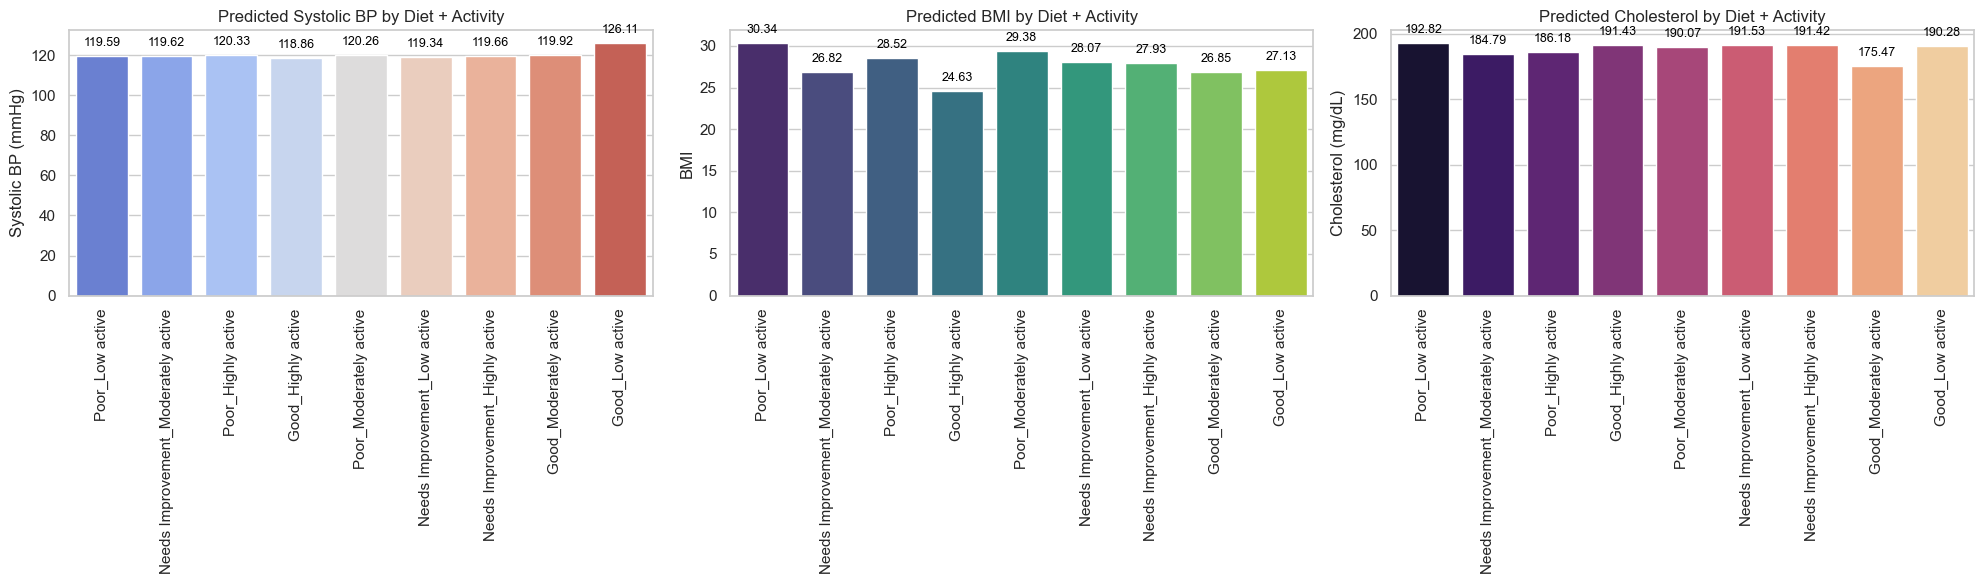

Combined plot saved to: outputs\plots\obj_1.4_combined_effects_diet_activity_all_outcomes.png


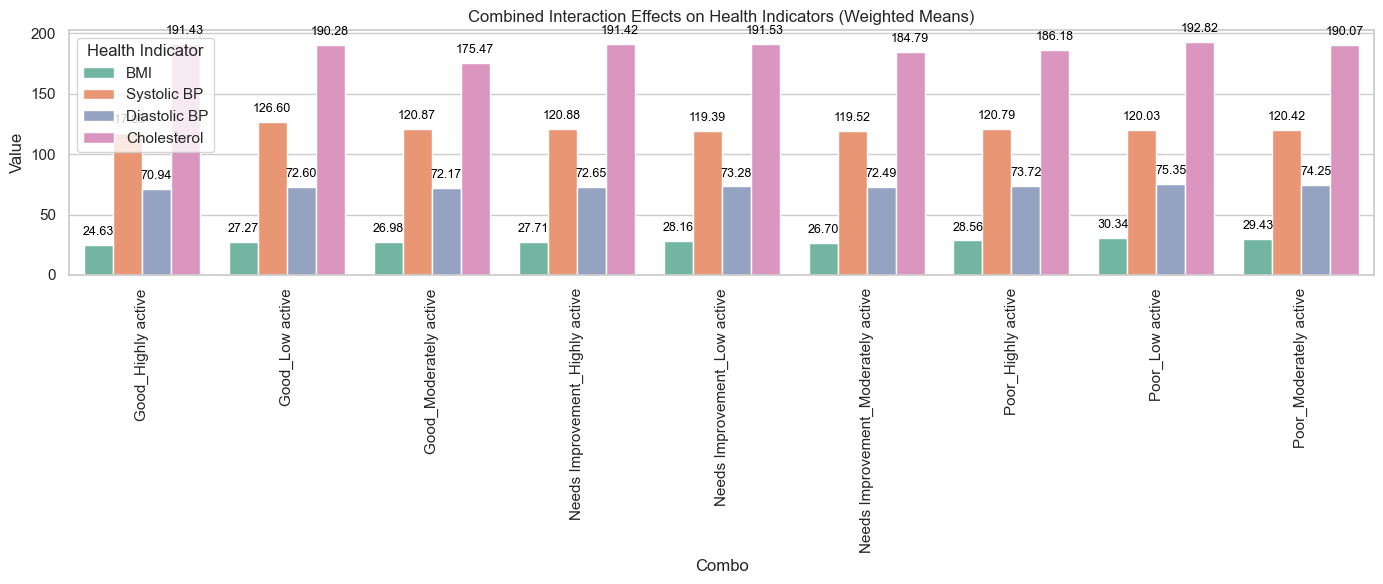

combined effects of diet quality and physical activity on clinical health indicators plot saved to: outputs\plots\obj_1.4_interaction_effects_diet_activity_clinical_indicators.png


In [4]:
# Predict + Combine results into one df
predict_df = combined_effect_data[['diet_score_category', 'activity_level']].drop_duplicates().copy()
predict_df['Combo'] = predict_df['diet_score_category'] + "_" + predict_df['activity_level']
predict_df['systolic_pred'] = model_sysbp.predict(predict_df)
predict_df['bmi_pred'] = model_bmi.predict(predict_df)
predict_df['chol_pred'] = model_chol.predict(predict_df)

#  Plot predicted values with bar labels

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)

# Helper function to annotate bars with >0.05 value and 2 decimal places
def annotate_bars(ax):
    for p in ax.patches:
        height = p.get_height()
        if height > 0.05 and not pd.isna(height):
            ax.annotate(f'{height:.2f}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 5),
                        textcoords='offset points')

# Systolic BP
sns.barplot(data=predict_df, x='Combo', y='systolic_pred', ax=axes[0], hue='Combo', legend=False, palette='coolwarm')
axes[0].set_title("Predicted Systolic BP by Diet + Activity")
axes[0].set_ylabel("Systolic BP (mmHg)")
axes[0].set_xlabel("")
axes[0].tick_params(axis='x', rotation=90)
annotate_bars(axes[0])

# BMI
sns.barplot(data=predict_df, x='Combo', y='bmi_pred', ax=axes[1], hue='Combo', legend=False, palette='viridis')
axes[1].set_title("Predicted BMI by Diet + Activity")
axes[1].set_ylabel("BMI")
axes[1].set_xlabel("")
axes[1].tick_params(axis='x', rotation=90)
annotate_bars(axes[1])

# Cholesterol
sns.barplot(data=predict_df, x='Combo', y='chol_pred', ax=axes[2], hue='Combo', legend=False, palette='magma')
axes[2].set_title("Predicted Cholesterol by Diet + Activity")
axes[2].set_ylabel("Cholesterol (mg/dL)")
axes[2].set_xlabel("")
axes[2].tick_params(axis='x', rotation=90)
annotate_bars(axes[2])

# Save combined plot
plt.tight_layout()
combined_plot_path = PLOTS_DIR / 'obj_1.4_combined_effects_diet_activity_all_outcomes.png'
plt.savefig(combined_plot_path)
plt.show()
print(f"Combined plot saved to: {pretty_path(combined_plot_path)}")

# Step 5: Weighted Mean Visualization

grouped = combined_effect_data.groupby(['diet_score_category', 'activity_level'], group_keys=False).apply(
    lambda g: pd.Series({
    'BMI': np.average(g['bmi'], weights=g['exam_sample_weight']) if g['exam_sample_weight'].sum() > 0 else np.nan,
    'Systolic BP': np.average(g['systolic_avg'], weights=g['exam_sample_weight']) if g['exam_sample_weight'].sum() > 0 else np.nan,
    'Diastolic BP': np.average(g['diastolic_avg'], weights=g['exam_sample_weight']) if g['exam_sample_weight'].sum() > 0 else np.nan,
    'Cholesterol': np.average(g['total_cholesterol'], weights=g['blood_drawn_sample_weight']) if g['blood_drawn_sample_weight'].sum() > 0 else np.nan
}),
    include_groups=False  # if your pandas version supports it
).reset_index()

grouped['Combo'] = grouped['diet_score_category'] + "_" + grouped['activity_level']
grouped_melted = grouped.melt(
    id_vars='Combo',
    value_vars=['BMI', 'Systolic BP', 'Diastolic BP', 'Cholesterol'],
    var_name='Health Indicator',
    value_name='Value'
)

plt.figure(figsize=(14, 6))
ax = sns.barplot(data=grouped_melted, x='Combo', y='Value', hue='Health Indicator', palette='Set2')
plt.title('Combined Interaction Effects on Health Indicators (Weighted Means)')
plt.xticks(rotation=90)

# Annotate bars
for p in ax.patches:
    height = p.get_height()
    if height > 0.05 and not pd.isna(height):
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
weighted_plot_path = PLOTS_DIR / "obj_1.4_interaction_effects_diet_activity_clinical_indicators.png"
plt.savefig(weighted_plot_path)
plt.show()
plt.close()

print(f"combined effects of diet quality and physical activity on clinical health indicators plot saved to: {pretty_path(weighted_plot_path)}")


### 2. Combined effects of blood pressure and glucose levels on cardiovascular disease - Analysis

***Looking at How Blood Pressure and Blood Sugar Together Affect Heart Disease***

I cleaned the data by removing rows with missing values for key info like blood pressure, glucose, age, gender, and diet. Then I made sure categories like gender and race were ready for analysis. Next, I ran a weighted logistic regression to see how blood pressure and blood sugar—especially their interaction—relate to heart disease risk. I used sample weights to reflect the population better and HC3 robust standard errors to make the results more reliable, especially since we had only two PSUs and couldn’t use standard clustering.

Finally, I saved the model summary to a text file for later review.

In [5]:

# 1. Copy and drop rows with missing data in required columns (including weights)
required_columns = [
    'bp_category', 'glucose_category', 'any_cvd',
    'age', 'gender', 'race_ethnicity', 'bmi',
    'diet_score_category', 'activity_level', 'fasting_subsample_weight'
]
cvd_df = df.copy().dropna(subset=required_columns)
print(f"Modeling rows of combined_effect_data: {len(cvd_df)}")

# 2. Convert categorical variables to category dtype
categorical_vars = [
    'bp_category', 'glucose_category', 'gender',
    'race_ethnicity', 'diet_score_category', 'activity_level'
]
for var in categorical_vars:
    cvd_df[var] = cvd_df[var].astype('category')

# 3. Ensure outcome is integer binary
cvd_df['any_cvd'] = cvd_df['any_cvd'].astype(int)

# 4. Fit weighted logistic regression using GLM with binomial family and freq_weights
model = sm.GLM.from_formula(
    formula=(
        'any_cvd ~ C(bp_category) * C(glucose_category) + age + '
        'C(gender) + C(race_ethnicity) + bmi + C(diet_score_category) + C(activity_level)'
    ),
    data=cvd_df,
    family=sm.families.Binomial(),
    freq_weights=cvd_df['fasting_subsample_weight']
).fit(cov_type='HC3')

print(model.summary())

# 5. Save model summary to a text file

summary_txt_path = SUMMARY_DIR / "obj_1.4_combined_effects_of_blood_pressure_and_glucose_levels_on_cardiovascular_disease_summary.txt"
with open(summary_txt_path, 'w') as f:
    f.write(model.summary().as_text())


print(f"combined effects of blood pressure and glucose levels on cardiovascular disease regression summary saved to {pretty_path(summary_txt_path)}")




Modeling rows of combined_effect_data: 1803
                 Generalized Linear Model Regression Results                  
Dep. Variable:                any_cvd   No. Observations:                 1803
Model:                            GLM   Df Residuals:             145597909.78
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5533e+07
Date:                Sat, 26 Jul 2025   Deviance:                   5.1066e+07
Time:                        14:30:23   Pearson chi2:                 1.79e+08
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:                  HC3                                         
                                                                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------

### 2. Combined effects of blood pressure and glucose levels on cardiovascular disease - Visualization

***Visualizing How Blood Pressure and Glucose Levels Affect Heart Disease Risk***

I take the model, just built and use it to predict the chance of having cardiovascular disease for each person in the data. Then, I group everyone by their blood pressure and glucose categories and calculate the average predicted risk for each group.

Once I've got those averages, I plot them in a bar chart. That way, it's super easy to compare and see which combinations (like high BP and high glucose) are linked with a higher risk. I even add the exact values on top of each bar to make it clear.

Finally, I save the plot as a PNG file so I can use it later in reports or presentations.

             bp_category glucose_category  count
10   Hypertensive Crisis      Prediabetes      4
9    Hypertensive Crisis           Normal      4
6   Hypertension Stage 2         Diabetes     43
0               Elevated         Diabetes     44
3   Hypertension Stage 1         Diabetes     52
11                Normal         Diabetes     62
1               Elevated           Normal     88
7   Hypertension Stage 2           Normal     97
2               Elevated      Prediabetes    126
8   Hypertension Stage 2      Prediabetes    140
4   Hypertension Stage 1           Normal    145
5   Hypertension Stage 1      Prediabetes    197
13                Normal      Prediabetes    334
12                Normal           Normal    467


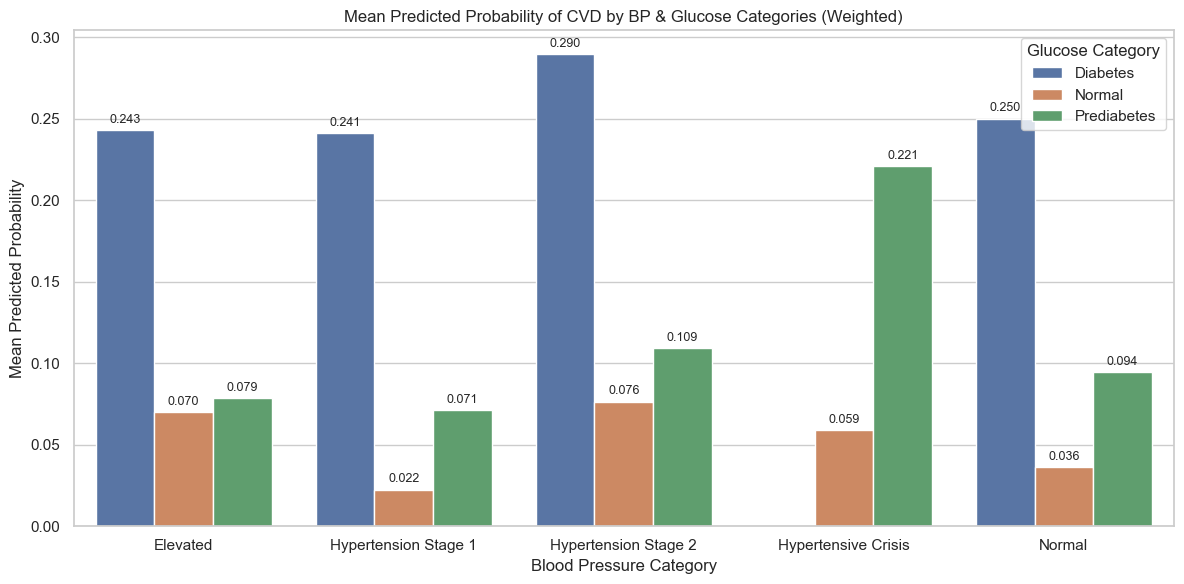

combined effects of blood pressure and glucose levels on cardiovascular disease plot saved to: outputs\plots\obj_1.4_combined_effects_of_blood_pressure_and_glucose_levels_on_cardiovascular_disease_plot.png


In [6]:
# 1. Predict probabilities
cvd_df['predicted_prob'] = model.predict(cvd_df)

# 2. Aggregate mean predicted probabilities by bp_category and glucose_category
grouped = cvd_df.groupby(['bp_category', 'glucose_category'], observed=True)['predicted_prob'].mean().reset_index()

group_counts = cvd_df.groupby(['bp_category', 'glucose_category'], observed=True).size().reset_index(name='count')
print(group_counts.sort_values('count'))

# 3. Plot barplot of mean predicted probabilities with values on bars
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    x='bp_category',
    y='predicted_prob',
    hue='glucose_category',
    data=grouped
)

plt.title('Mean Predicted Probability of CVD by BP & Glucose Categories (Weighted)')
plt.ylabel('Mean Predicted Probability')
plt.xlabel('Blood Pressure Category')
plt.legend(title='Glucose Category')

# 4. Add values on top of bars
for p in barplot.patches:
    height = p.get_height()
    
    # Show label only if value is above 0.005
    if height > 0.005:
        barplot.annotate(
            f'{height:.3f}',  # round to 3 decimal places
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='bottom',
            fontsize=9,
            xytext=(0, 3),  # small vertical offset
            textcoords='offset points'
        )

plt.tight_layout()

# 5. Save plot as PNG file

plot_path = PLOTS_DIR/'obj_1.4_combined_effects_of_blood_pressure_and_glucose_levels_on_cardiovascular_disease_plot.png'
plt.savefig(plot_path)

plt.show()
plt.close()

print(f"combined effects of blood pressure and glucose levels on cardiovascular disease plot saved to: {pretty_path(plot_path)}")


***NOTES:***

At first, I tried adding the survey’s grouping info—called strata—into the model to better reflect how the data was collected. But that caused some issues because those groups were too closely tied to other variables, which made the model unstable. So instead, I left out the strata and used the sample weights together with something called HC3 robust standard errors. That helps make the results more reliable, even without the full survey structure. Since there are only two main sampling groups (called PSUs), I couldn’t fully adjust for those either—so it's good to keep that in mind when looking at the results.